In [1]:
import numpy as np
import pandas as pd


# Sklearn
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score # evaluation metric used for leaderboard scoring in this competition
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
# Statistics
import scipy.stats as stats

# Visualization
from matplotlib import pyplot as plt # pyplot is an easy to use scripting interface for plotting as oppose to more advanced artistic interface
import seaborn as sns # seaborn is even higher level graphing library built on top of matplotlib

# Machine learning
import optuna # used for finding good hyperparameters for a model
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
train = pd.read_csv(r'resources/train_essays.csv')
test = pd.read_csv(r'resources/test_essays.csv')
train_prompts = pd.read_csv(r'resources/train_prompts.csv')

In [3]:
def inspect_columns(df):
    """A helper function that does a better job than df.info() and df.describe()"""
    
    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,#是否有相同的元素
        'cardinality': df.nunique(),#不同元素的个数
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,

    })
    
    return result

In [4]:
inspect_columns(train)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
id,1378,0,True,1378,False,0.0,0059830c,6a359a1b,ffe1ca0d,object
prompt_id,1378,0,False,2,False,0.0,0,1,0,int64
text,1378,0,True,1378,False,0.0,Cars. Cars have been around since they became ...,"Dear State Senator, Everyone has their very ow...",Cars have been around since the 1800's and hav...,object
generated,1378,0,False,2,False,0.0,0,0,0,int64


In [5]:
def categorize_columns(train, target_variable):
    numerical_data_types = ['int64', 'float64', 'datetime64[ns]']  # adjusted data types
    categorical_data_types = ['object']

    numerical_columns = [column for column in train.columns if train[column].dtype in numerical_data_types]
    if target_variable in numerical_columns:
        numerical_columns.remove(target_variable)
    print(f"Numerical variables ({len(numerical_columns)}): {numerical_columns}")

    categorical_columns = [column for column in train.columns if train[column].dtype in categorical_data_types]
    
    if target_variable in categorical_columns:
        categorical_columns.remove(target_variable)
    print(f"Categorical variables ({len(categorical_columns)}): {categorical_columns}")

    return numerical_columns, categorical_columns

In [6]:
numerical_columns, categorical_columns = categorize_columns(train=train, target_variable='generated')

Numerical variables (1): ['prompt_id']
Categorical variables (2): ['id', 'text']


In [7]:
from IPython.display import display
display(test.head())

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


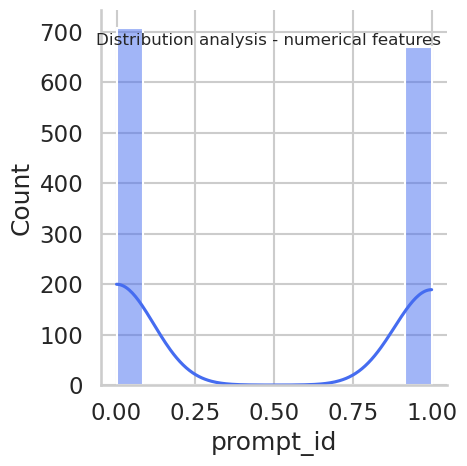

In [8]:
sns.set_style("whitegrid")
sns.set_context("talk")
custom_palette = ['#456cf0', '#ed7647']
sns.set_palette(custom_palette)

sns.displot(train.prompt_id, kde=True)

plt.suptitle(f'Distribution analysis - numerical features',fontsize = 12, y = 0.9, x = 0.57)
plt.show()

In [9]:
train_df = pd.DataFrame(train)
train_prompts_df = pd.DataFrame(train_prompts)
merged_df = pd.merge(train_df, train_prompts_df, on='prompt_id', how='inner')

In [10]:
merged_df

,id,prompt_id,text,generated,prompt_name,instructions,source_text
0,0059830c,0,Cars. Cars have been around since they became ...,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,005db917,0,Transportation is a large necessity in most co...,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
3,00940276,0,How often do you ride in a car? Do you drive a...,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
...,...,...,...,...,...,...,...
1373,fc66f374,1,The Electoral College was originally establish...,0,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...
1374,fcb87d59,1,"Dear senator, I think that the presidential el...",0,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...
1375,fcd93e2d,1,The electoral college is a group of electors t...,0,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...
1376,fcfe84cb,1,An electoral College compromises between elect...,0,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [11]:
inspect_columns(merged_df)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
id,1378,0,True,1378,False,0.0,0059830c,5a3184fb,fe6ff9a5,object
prompt_id,1378,0,False,2,False,0.0,0,1,1,int64
text,1378,0,True,1378,False,0.0,Cars. Cars have been around since they became ...,"Dear Senator of Florida, I believe the elector...",There has been a fuss about the Elector Colleg...,object
generated,1378,0,False,2,False,0.0,0,0,0,int64
prompt_name,1378,0,False,2,False,0.0,Car-free cities,Does the electoral college work?,Does the electoral college work?,object
instructions,1378,0,False,2,False,0.0,Write an explanatory essay to inform fellow ci...,Write a letter to your state senator in which ...,Write a letter to your state senator in which ...,object
source_text,1378,0,False,2,False,0.0,"# In German Suburb, Life Goes On Without Cars ...",# What Is the Electoral College? by the Office...,# What Is the Electoral College? by the Office...,object


In [12]:
encoded_df = pd.get_dummies(merged_df, columns=['text', 'prompt_name', 'instructions', 'source_text', 'id'])

In [13]:
inspect_columns(encoded_df)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
prompt_id,1378,0,False,2,False,0.0,0,0,1,int64
generated,1378,0,False,2,False,0.0,0,0,0,int64
"text_"" All of our development since World War 2 has been centered on the car..."" Now and days alot of countries are limiting car usage to go into a day of free car day, which basically means that no one is allowed to drive their motor running cars for a day. If they disobey the law they will be charge a fine. Its like a when a police officer stops you for passing a red light or for speeding on a no speeding zone. Still these countries are getting advantages over these days because there will be less smog, less traffic, and more people buying bicycles rather than a expensive car.\n\n"" Congestion was down 60 percent in the capital of France, after fivedays of intensifying smog."" one of the advantages for limiting car use is there will be less smog to deal with in the air. this can harm not only us but our environment we live in, which is the air we breath. In france they decide to do a car ban day. The result of this event was that the "" Cold nights and warm days caused the warmer layer of air to trap car emissions"". If someone was brave enough to drive a car than they will be fined 22euro which is 31.\n\n"" Almost 4,000 drivers were fined according to Reuters, people had their cars impounded for their reaction to the fine"". Less traffic was on the streets due this ban of cars, which allowed the people with bicycles to go on the streets and ride them. In Bogota,Colombia they also did this ban but they gained more advantages over limiting car usage, only buses and taxis were permitted to drive on the streets. their goal was to promote alternative transportation. Due to this event, parks and sports centers were packed throughout the city, and pitted sidewalks have been replaced by smooth sidewalks for the skateboards and bikes.\n\n"" What most intrigues me is that rates of car ownership per household and per person started to come down two to three years before downturn said Micheal siva"". As a result of car ban people have stop buying cars which is atrocious for car companies but at the same time there is a up side to this also and is that people will now walk or ride bicycles to get to where they need. Which also leads to people being more athletic and less people being obese or overweight.\n\nThese countries are gaining alot because of these car ban which is good for removing these dark clouds in the air, less traffic, and people riding bicycles rather than cars. Its obviusly that some people think that this rule is selfish or not needed but its helps more than you think it does. And some people are just mad because of what they are getting charged or fine for driving in the streets even though you can't due to the law.",1378,0,False,2,False,0.0,0,0,0,uint8
"text_"" The Electoral College is a process, not a place."" reported by the Office of the Federal Register. The Electoral College was established by our founding fathers. The main reason it was established was because it was a compromise between electing the President by a vote in Congress and electing the President by a popular vote of qualified citizens. The Electoral College is a timely and outdated process that consists of selecting the electors, the meeting of the electors where they vote for the President and Vice President, and counting of the electoral votes by Congress. Yes, the Electoral College has helped the United States of America but it has also caused us many major conflicts that no citizen can change. Many Americans are not heard and by demolishing the Electoral College and bringing our ""old friend"" popular vote back in majority of Americans will be heard. This is a free country right? Do we have the right to be heard and vote for ourselves? I strongly believe we do. I vehemently feel that the United States of America should use popular vote due to

In [14]:
y = encoded_df['generated']


In [15]:
X = encoded_df.drop('generated', axis=1)

In [16]:
X

prompt_id  \
0             0   
1             0   
2             0   
3             0   
4             0   
...         ...   
1373          1   
1374          1   
1375          1   
1376          1   
1377          1   

      text_" All of our development since World War 2 has been centered on the car..." Now and days alot of countries are limiting car usage to go into a day of free car day, which basically means that no one is allowed to drive their motor running cars for a day. If they disobey the law they will be charge a fine. Its like a when a police officer stops you for passing a red light or for speeding on a no speeding zone. Still these countries are getting advantages over these days because there will be less smog, less traffic, and more people buying bicycles rather than a expensive car.\n\n" Congestion was down 60 percent in the capital of France, after fivedays of intensifying smog." one of the advantages for limiting car use is there will be less smog to deal with in the air. this can harm not only us but our environment we live in, which is the air we breath. In france they decide to do a car ban day. The result of this event was that the " Cold nights and warm days caused the warmer layer of air to trap car emissions". If someone was brave enough to drive a car than they will be fined 22euro which is 31.\n\n" Almost 4,000 drivers were fined according to Reuters, people had their cars impounded for their reaction to the fine". Less traffic was on the streets due this ban of cars, which allowed the people with bicycles to go on the streets and ride them. In Bogota,Colombia they also did this ban but they gained more advantages over limiting car usage, only buses and taxis were permitted to drive on the streets. their goal was to promote alternative transportation. Due to this event, parks and sports centers were packed throughout the city, and pitted sidewalks have been replaced by smooth sidewalks for the skateboards and bikes.\n\n" What most intrigues me is that rates of car ownership per household and per person started to come down two to three years before downturn said Micheal siva". As a result of car ban people have stop buying cars which is atrocious for car companies but at the same time there is a up side to this also and is that people will now walk or ride bicycles to get to where they need. Which also leads to people being more athletic and less people being obese or overweight.\n\nThese countries are gaining alot because of these car ban which is good for removing these dark clouds in the air, less traffic, and people riding bicycles rather than cars. Its obviusly that some people think that this rule is selfish or not needed but its helps more than you think it does. And some people are just mad because of what they are getting charged or fine for driving in the streets even though you can't due to the law.  \
0                                                     0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

def predict(ml_model):
    print("Model is: ", ml_model)
    
    model = ml_model.fit(X_train, y_train)
    
    print("Training score: ", model.score(X_train,y_train))
    
    predictions = model.predict(X_test)
    print("Predictions: ", predictions)
    print('-----------------')
    r2score = r2_score(y_test, predictions)
    print("r2 score is: ", r2score)
    
    print('MAE:{}', mean_absolute_error(y_test,predictions))
    print('MSE:{}', mean_squared_error(y_test,predictions))
    print('RMSE:{}', np.sqrt(mean_squared_error(y_test,predictions)))
    print('真实值和预测值的差值{}', y_test - predictions)

In [19]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression   
# k近邻回归
from sklearn.neighbors import KNeighborsRegressor  
# 决策树回归
from sklearn.tree import DecisionTreeRegressor  
# 梯度提升回归，随机森林回归
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor  

In [20]:
predict(LogisticRegression())

Model is:  LogisticRegression()
Training score:  0.9990925589836661
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
-----------------
r2 score is:  -0.007299270072992581
MAE:{} 0.007246376811594203
MSE:{} 0.007246376811594203
RMSE:{} 0.08512565307587486
真实值和预测值的差值{} 597     0
700     0
1222    0
1145    0
602     0
       ..
506     0
615     0
365     0
828     0
1281    0
Name: generated, Length: 276, dtype: int64


In [21]:
predict(RandomForestRegressor())

Model is:  RandomForestRegressor()
Training score:  0.8702822888283379
Predictions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------
r2 score is:  -0.007299270072992581
MAE:{} 0.00724637681